## 1. Setup & Imports

In [1]:
import json
from pathlib import Path
from typing import Dict, List, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

## 2. Configuration

In [14]:
# Project paths
PROJECT_ROOT = Path(r"e:\container-id-research")
ROI_DIR = PROJECT_ROOT / "data" / "interim" / "processed_rois"
OUTPUT_DIR = PROJECT_ROOT / "data" / "interim"

# Brightness parameters (Gaussian function)
BRIGHTNESS_TARGET = 100  # Optimal luminance (0-255)
BRIGHTNESS_SIGMA = 65  # Tolerance bandwidth
BRIGHTNESS_THRESHOLD = 0.25  # Minimum acceptable Q_B score

# Contrast parameters (Sigmoid function)
CONTRAST_TARGET = 50  # Minimum robust range (P95 - P5)
CONTRAST_K = 0.1  # Sigmoid slope
CONTRAST_THRESHOLD = 0.3  # Minimum acceptable Q_C score

print(f"ROI directory: {ROI_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nBrightness Criteria:")
print(f"  Target: {BRIGHTNESS_TARGET}, Sigma: {BRIGHTNESS_SIGMA}")
print(f"  Threshold Q_B: {BRIGHTNESS_THRESHOLD:.1%}")
print(f"\nContrast Criteria:")
print(f"  Target: {CONTRAST_TARGET}, Slope k: {CONTRAST_K}")
print(f"  Threshold Q_C: {CONTRAST_THRESHOLD:.1%}")

ROI directory: e:\container-id-research\data\interim\processed_rois
Output directory: e:\container-id-research\data\interim

Brightness Criteria:
  Target: 100, Sigma: 65
  Threshold Q_B: 25.0%

Contrast Criteria:
  Target: 50, Slope k: 0.1
  Threshold Q_C: 30.0%


## 3. Photometric Metric Functions

In [15]:
def calculate_brightness_metric(img_gray: np.ndarray) -> float:
    """
    Calculate brightness metric as the median (P50) of luminance histogram.

    Args:
        img_gray: Grayscale image (H x W, uint8)

    Returns:
        M_B: Brightness metric (0-255)
    """
    median = np.median(img_gray)
    return float(median)


def calculate_contrast_metric(img_gray: np.ndarray) -> float:
    """
    Calculate contrast metric as robust range (P95 - P5) of luminance histogram.

    Args:
        img_gray: Grayscale image (H x W, uint8)

    Returns:
        M_C: Contrast metric (0-255)
    """
    p5 = np.percentile(img_gray, 5)
    p95 = np.percentile(img_gray, 95)
    return float(p95 - p5)


# Test the metric functions
test_img = np.random.randint(0, 256, (100, 100), dtype=np.uint8)
m_b = calculate_brightness_metric(test_img)
m_c = calculate_contrast_metric(test_img)

print(f"Test image (100x100 random):")
print(f"  Brightness metric M_B: {m_b:.2f}")
print(f"  Contrast metric M_C: {m_c:.2f}")

Test image (100x100 random):
  Brightness metric M_B: 127.00
  Contrast metric M_C: 230.00


## 4. Quality Mapping Functions

In [16]:
def brightness_quality_gaussian(
    m_b: float, target: float = 128, sigma: float = 50
) -> float:
    """
    Map brightness metric to quality score using Gaussian function.

    Q_B = exp(-(M_B - target)^2 / (2 * sigma^2))

    Args:
        m_b: Brightness metric (0-255)
        target: Optimal brightness value (default: 128)
        sigma: Tolerance bandwidth (default: 50)

    Returns:
        Q_B: Quality score (0.0-1.0)
    """
    exponent = -((m_b - target) ** 2) / (2 * sigma**2)
    return float(np.exp(exponent))


def contrast_quality_sigmoid(m_c: float, target: float = 50, k: float = 0.1) -> float:
    """
    Map contrast metric to quality score using Sigmoid function.

    Q_C = 1 / (1 + exp(-k * (M_C - target)))

    Args:
        m_c: Contrast metric (0-255)
        target: Minimum acceptable contrast (default: 50)
        k: Slope parameter (default: 0.1)

    Returns:
        Q_C: Quality score (0.0-1.0)
    """
    exponent = -k * (m_c - target)
    return float(1.0 / (1.0 + np.exp(exponent)))


# Test quality functions
test_cases = [
    (128, 100),  # Ideal brightness, good contrast
    (50, 150),  # Dark, high contrast
    (200, 20),  # Bright, low contrast
]

print("Test quality mapping functions:")
for m_b, m_c in test_cases:
    q_b = brightness_quality_gaussian(m_b, BRIGHTNESS_TARGET, BRIGHTNESS_SIGMA)
    q_c = contrast_quality_sigmoid(m_c, CONTRAST_TARGET, CONTRAST_K)
    print(f"  M_B={m_b:3d}, M_C={m_c:3d} -> Q_B={q_b:.3f}, Q_C={q_c:.3f}")

Test quality mapping functions:
  M_B=128, M_C=100 -> Q_B=0.911, Q_C=0.993
  M_B= 50, M_C=150 -> Q_B=0.744, Q_C=1.000
  M_B=200, M_C= 20 -> Q_B=0.306, Q_C=0.047


## 5. Photometric Analysis Pipeline

In [17]:
def analyze_photometric(
    img_path: Path,
    brightness_threshold: float = 0.3,
    contrast_threshold: float = 0.3,
) -> Dict:
    """
    Perform photometric analysis on an image.

    Args:
        img_path: Path to ROI image
        brightness_threshold: Minimum Q_B score to pass
        contrast_threshold: Minimum Q_C score to pass

    Returns:
        Dictionary with analysis results
    """
    # Load image and convert to grayscale
    img = cv2.imread(str(img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate metrics
    m_b = calculate_brightness_metric(img_gray)
    m_c = calculate_contrast_metric(img_gray)

    # Calculate quality scores
    q_b = brightness_quality_gaussian(m_b, BRIGHTNESS_TARGET, BRIGHTNESS_SIGMA)
    q_c = contrast_quality_sigmoid(m_c, CONTRAST_TARGET, CONTRAST_K)

    # Determine pass/reject
    passed = q_b >= brightness_threshold and q_c >= contrast_threshold

    # Determine rejection reason
    if passed:
        reason = "PASS"
    elif q_b < brightness_threshold and q_c < contrast_threshold:
        reason = "LOW_BRIGHTNESS_AND_CONTRAST"
    elif q_b < brightness_threshold:
        reason = "LOW_BRIGHTNESS"
    else:
        reason = "LOW_CONTRAST"

    return {
        "file_name": img_path.name,
        "m_b": m_b,
        "m_c": m_c,
        "q_b": q_b,
        "q_c": q_c,
        "passed": passed,
        "reason": reason,
    }


# Test on a sample image
sample_images = list(ROI_DIR.glob("*.jpg"))[:3]
print(f"Testing on {len(sample_images)} sample images:\n")

for img_path in sample_images:
    result = analyze_photometric(img_path, BRIGHTNESS_THRESHOLD, CONTRAST_THRESHOLD)
    print(f"{result['file_name']}:")
    print(f"  M_B={result['m_b']:.1f}, M_C={result['m_c']:.1f}")
    print(f"  Q_B={result['q_b']:.3f}, Q_C={result['q_c']:.3f}")
    print(f"  Result: {result['reason']}\n")

Testing on 3 sample images:

0000065.jpg:
  M_B=50.0, M_C=132.0
  Q_B=0.744, Q_C=1.000
  Result: PASS

0000088.jpg:
  M_B=99.0, M_C=186.0
  Q_B=1.000, Q_C=1.000
  Result: PASS

0000089.jpg:
  M_B=84.0, M_C=140.0
  Q_B=0.970, Q_C=1.000
  Result: PASS



## 6. Process All ROIs

In [18]:
# Get all ROI images
roi_images = sorted(ROI_DIR.glob("*.jpg"))
print(f"Found {len(roi_images)} ROI images")

# Process all images
results = []
for img_path in tqdm(roi_images, desc="Photometric analysis"):
    result = analyze_photometric(img_path, BRIGHTNESS_THRESHOLD, CONTRAST_THRESHOLD)
    results.append(result)

# Statistics
pass_count = sum(1 for r in results if r["passed"])
reject_count = len(results) - pass_count

print(f"\n✓ Photometric analysis complete!")
print(f"  Total images: {len(results)}")
print(f"  Passed: {pass_count} ({pass_count/len(results)*100:.1f}%)")
print(f"  Rejected: {reject_count} ({reject_count/len(results)*100:.1f}%)")

Found 704 ROI images


Photometric analysis:   0%|          | 0/704 [00:00<?, ?it/s]


✓ Photometric analysis complete!
  Total images: 704
  Passed: 704 (100.0%)
  Rejected: 0 (0.0%)


## 7. Statistics & Analysis

In [ ]:
# Rejection reasons
reject_reasons = {}
for r in results:
    if not r["passed"]:
        reason = r["reason"]
        reject_reasons[reason] = reject_reasons.get(reason, 0) + 1

print("=== Rejection Reasons ===")
for reason, count in sorted(reject_reasons.items(), key=lambda x: x[1], reverse=True):
    percentage = count / len(results) * 100
    print(f"  {reason}: {count} ({percentage:.1f}%)")

=== Rejection Reasons ===


: 

In [8]:
# Metric statistics
m_b_values = [r["m_b"] for r in results]
m_c_values = [r["m_c"] for r in results]
q_b_values = [r["q_b"] for r in results]
q_c_values = [r["q_c"] for r in results]

print("\n=== Brightness Metric (M_B) Statistics ===")
print(f"  Min:    {np.min(m_b_values):.1f}")
print(f"  Max:    {np.max(m_b_values):.1f}")
print(f"  Mean:   {np.mean(m_b_values):.1f}")
print(f"  Median: {np.median(m_b_values):.1f}")
print(f"  Std:    {np.std(m_b_values):.1f}")

print("\n=== Contrast Metric (M_C) Statistics ===")
print(f"  Min:    {np.min(m_c_values):.1f}")
print(f"  Max:    {np.max(m_c_values):.1f}")
print(f"  Mean:   {np.mean(m_c_values):.1f}")
print(f"  Median: {np.median(m_c_values):.1f}")
print(f"  Std:    {np.std(m_c_values):.1f}")

print("\n=== Brightness Quality (Q_B) Statistics ===")
print(f"  Min:    {np.min(q_b_values):.3f}")
print(f"  Max:    {np.max(q_b_values):.3f}")
print(f"  Mean:   {np.mean(q_b_values):.3f}")
print(f"  Median: {np.median(q_b_values):.3f}")

print("\n=== Contrast Quality (Q_C) Statistics ===")
print(f"  Min:    {np.min(q_c_values):.3f}")
print(f"  Max:    {np.max(q_c_values):.3f}")
print(f"  Mean:   {np.mean(q_c_values):.3f}")
print(f"  Median: {np.median(q_c_values):.3f}")


=== Brightness Metric (M_B) Statistics ===
  Min:    29.0
  Max:    205.0
  Mean:   104.1
  Median: 104.0
  Std:    27.8

=== Contrast Metric (M_C) Statistics ===
  Min:    63.0
  Max:    226.0
  Mean:   159.0
  Median: 162.0
  Std:    30.0

=== Brightness Quality (Q_B) Statistics ===
  Min:    0.141
  Max:    1.000
  Mean:   0.799
  Median: 0.864

=== Contrast Quality (Q_C) Statistics ===
  Min:    0.786
  Max:    1.000
  Mean:   0.998
  Median: 1.000


## 8. Visualizations

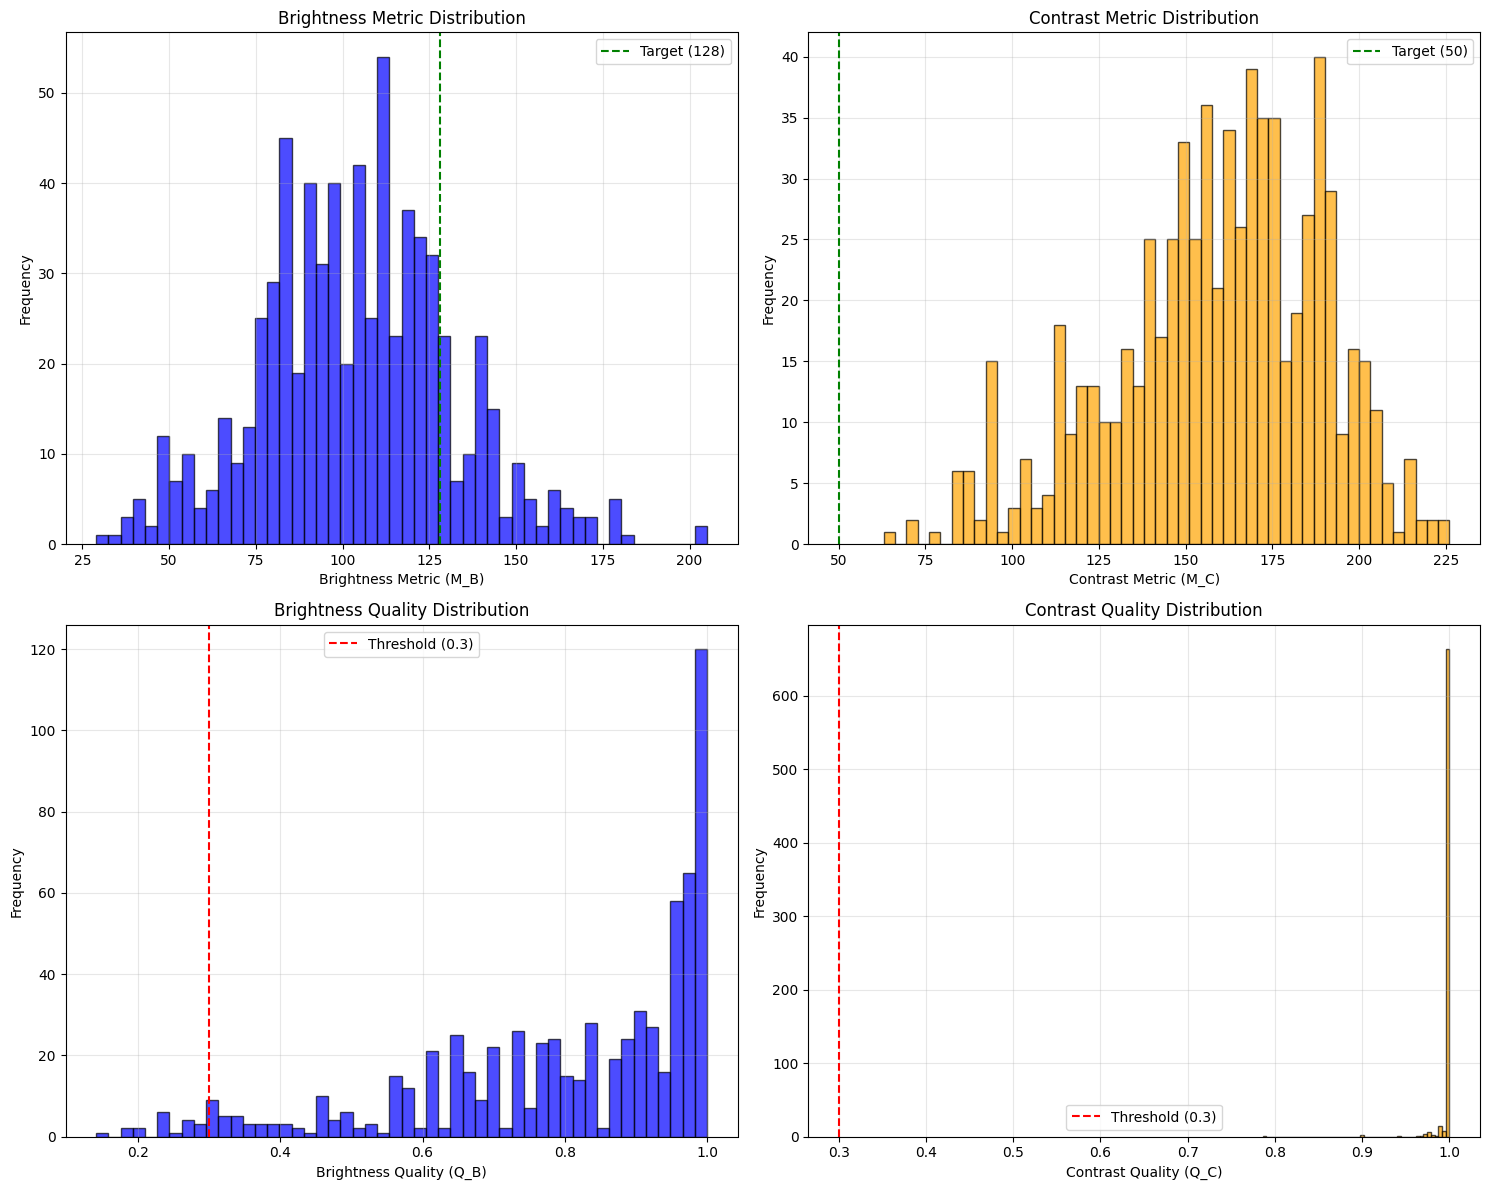

In [9]:
# Plot metric distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# M_B distribution
axes[0, 0].hist(m_b_values, bins=50, alpha=0.7, color="blue", edgecolor="black")
axes[0, 0].axvline(
    BRIGHTNESS_TARGET,
    color="green",
    linestyle="--",
    label=f"Target ({BRIGHTNESS_TARGET})",
)
axes[0, 0].set_xlabel("Brightness Metric (M_B)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Brightness Metric Distribution")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# M_C distribution
axes[0, 1].hist(m_c_values, bins=50, alpha=0.7, color="orange", edgecolor="black")
axes[0, 1].axvline(
    CONTRAST_TARGET, color="green", linestyle="--", label=f"Target ({CONTRAST_TARGET})"
)
axes[0, 1].set_xlabel("Contrast Metric (M_C)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Contrast Metric Distribution")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Q_B distribution
axes[1, 0].hist(q_b_values, bins=50, alpha=0.7, color="blue", edgecolor="black")
axes[1, 0].axvline(
    BRIGHTNESS_THRESHOLD,
    color="red",
    linestyle="--",
    label=f"Threshold ({BRIGHTNESS_THRESHOLD})",
)
axes[1, 0].set_xlabel("Brightness Quality (Q_B)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Brightness Quality Distribution")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q_C distribution
axes[1, 1].hist(q_c_values, bins=50, alpha=0.7, color="orange", edgecolor="black")
axes[1, 1].axvline(
    CONTRAST_THRESHOLD,
    color="red",
    linestyle="--",
    label=f"Threshold ({CONTRAST_THRESHOLD})",
)
axes[1, 1].set_xlabel("Contrast Quality (Q_C)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Contrast Quality Distribution")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

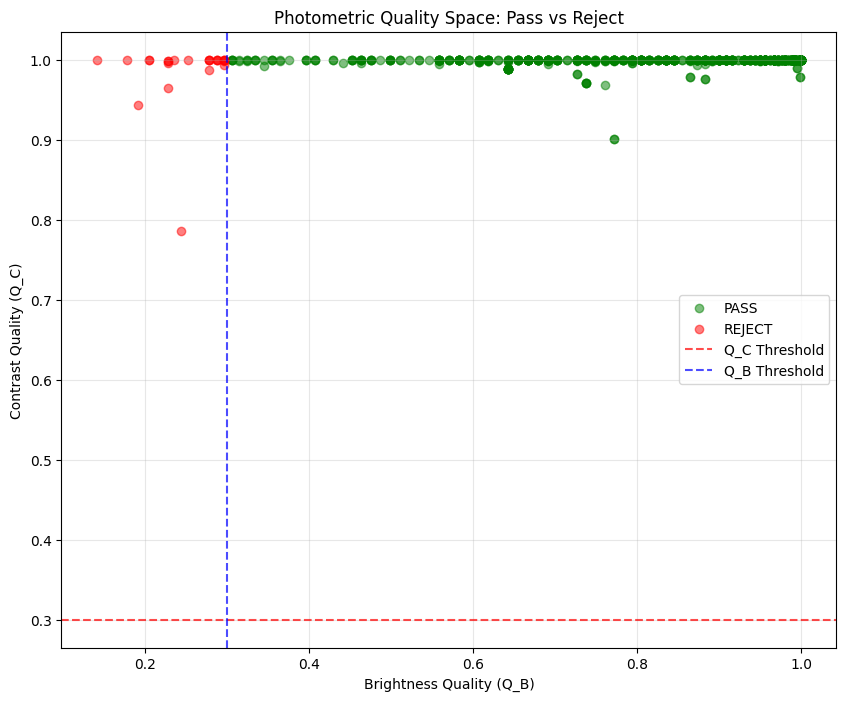

In [10]:
# Scatter plot: Q_B vs Q_C
passed_indices = [i for i, r in enumerate(results) if r["passed"]]
rejected_indices = [i for i, r in enumerate(results) if not r["passed"]]

q_b_passed = [q_b_values[i] for i in passed_indices]
q_c_passed = [q_c_values[i] for i in passed_indices]
q_b_rejected = [q_b_values[i] for i in rejected_indices]
q_c_rejected = [q_c_values[i] for i in rejected_indices]

plt.figure(figsize=(10, 8))
plt.scatter(q_b_passed, q_c_passed, c="green", alpha=0.5, label="PASS")
plt.scatter(q_b_rejected, q_c_rejected, c="red", alpha=0.5, label="REJECT")
plt.axhline(
    CONTRAST_THRESHOLD, color="red", linestyle="--", alpha=0.7, label="Q_C Threshold"
)
plt.axvline(
    BRIGHTNESS_THRESHOLD,
    color="blue",
    linestyle="--",
    alpha=0.7,
    label="Q_B Threshold",
)
plt.xlabel("Brightness Quality (Q_B)")
plt.ylabel("Contrast Quality (Q_C)")
plt.title("Photometric Quality Space: Pass vs Reject")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Visualize Sample Images

=== Sample PASS Images ===


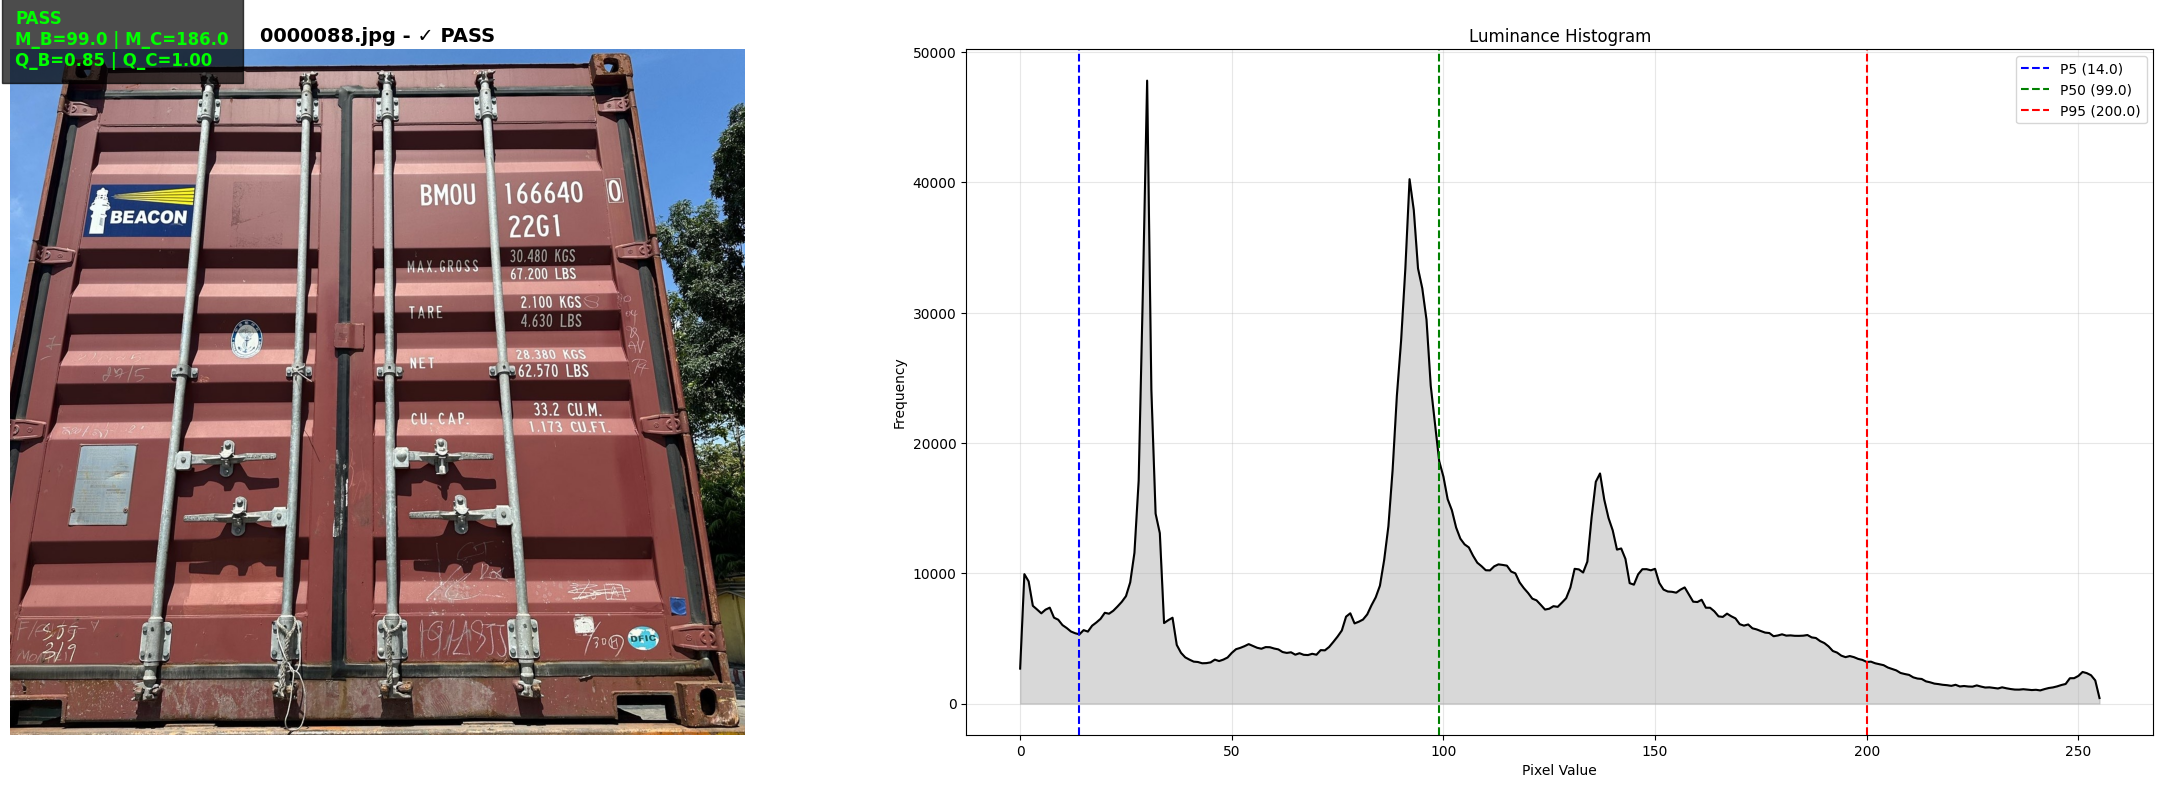

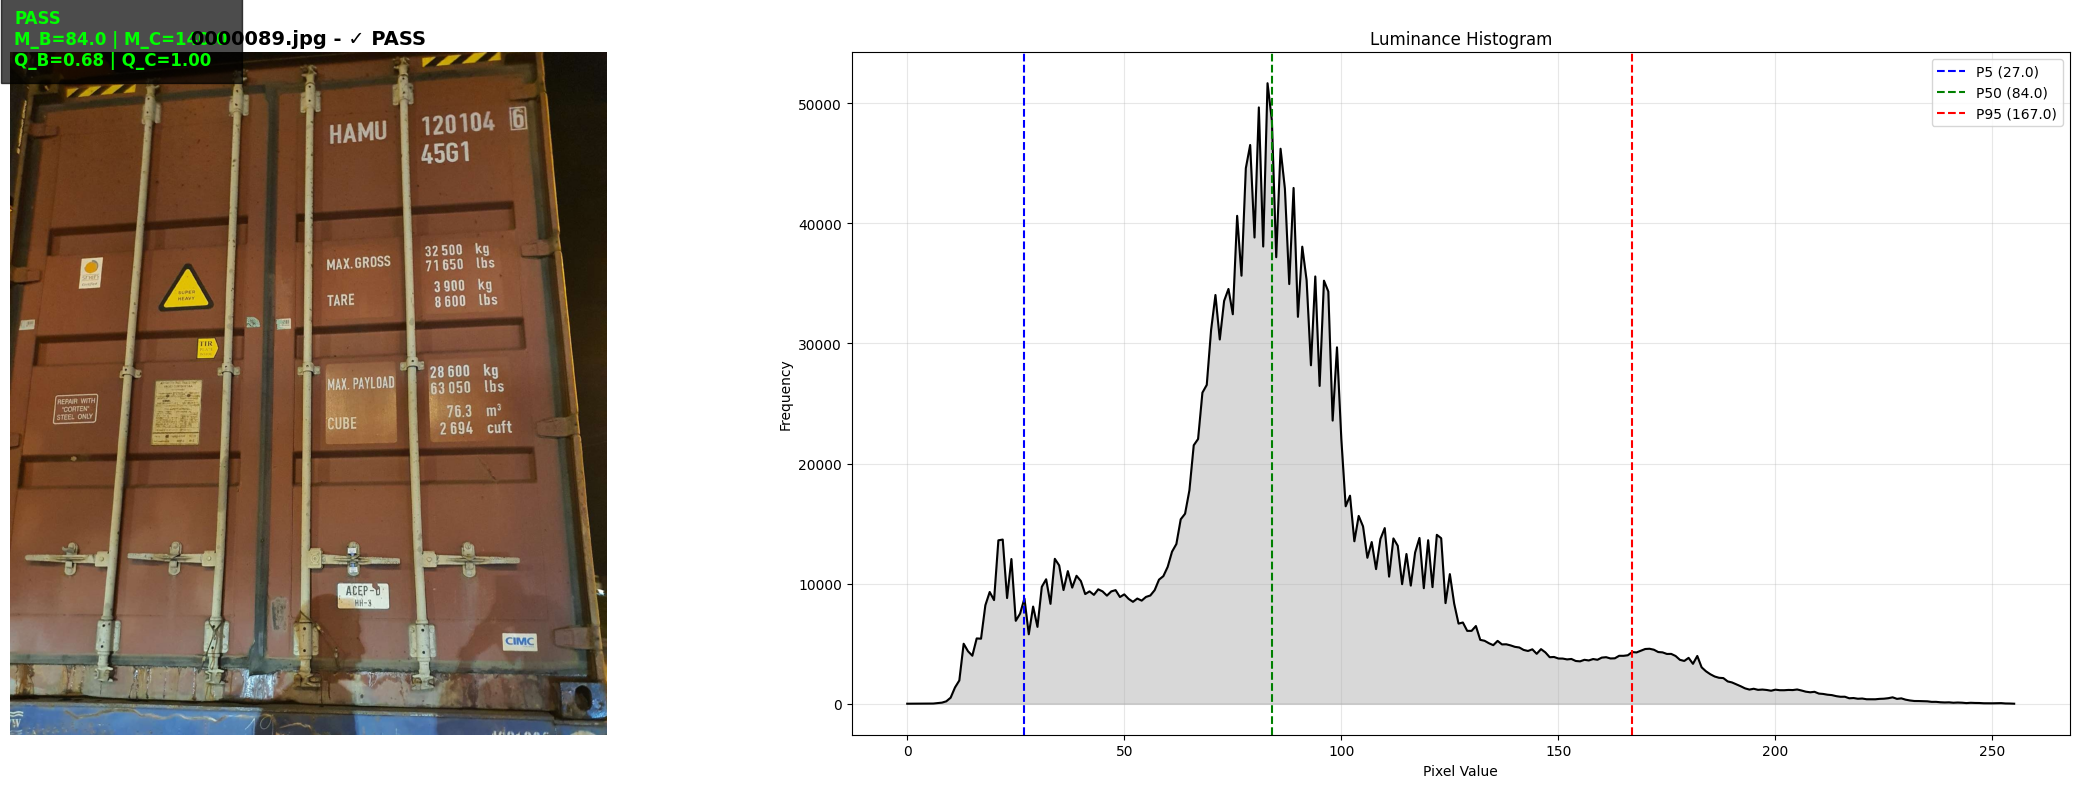

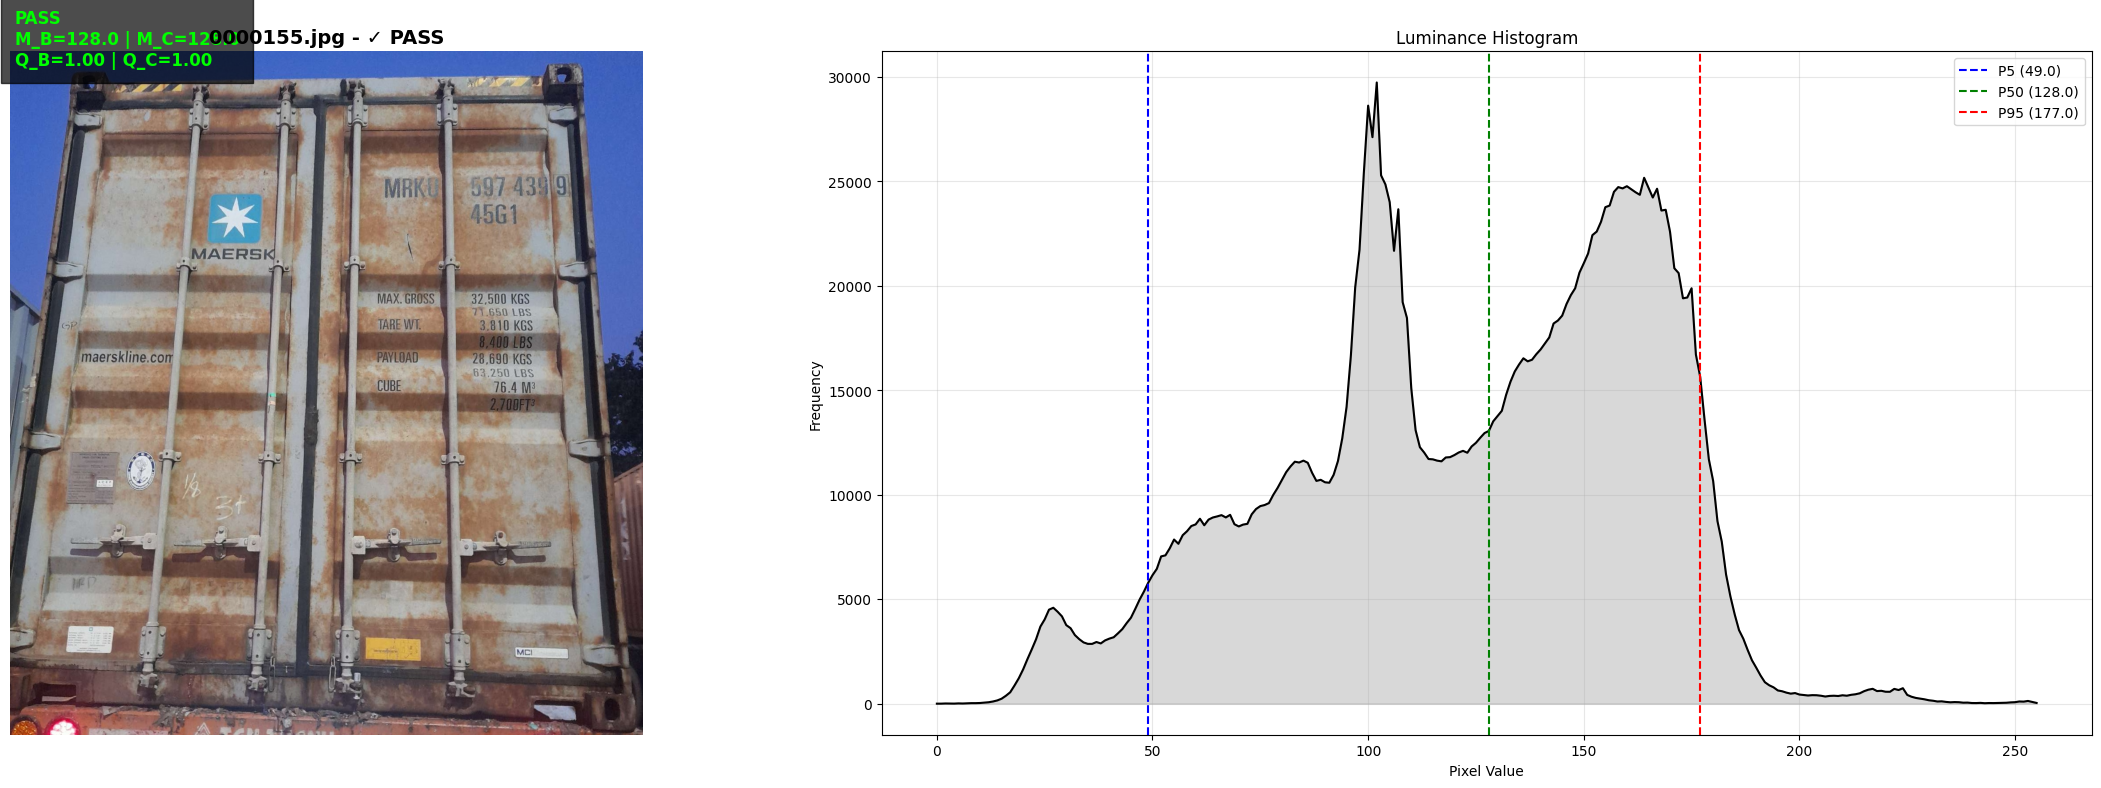

In [11]:
def visualize_photometric(result: Dict, show_histogram: bool = True) -> None:
    """
    Visualize photometric analysis result with image and histogram.

    Args:
        result: Result dictionary from photometric analysis
        show_histogram: Whether to show the histogram
    """
    file_name = result["file_name"]
    m_b = result["m_b"]
    m_c = result["m_c"]
    q_b = result["q_b"]
    q_c = result["q_c"]
    passed = result["passed"]
    reason = result["reason"]

    # Load image
    img_path = ROI_DIR / file_name
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Create figure
    n_plots = 2 if show_histogram else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(12 * n_plots, 8))

    if n_plots == 1:
        axes = [axes]

    # Plot 1: Image with metrics
    axes[0].imshow(img_rgb)
    color = "lime" if passed else "red"
    status = "✓ PASS" if passed else "✗ REJECT"

    label_text = (
        f"{reason}\nM_B={m_b:.1f} | M_C={m_c:.1f}\nQ_B={q_b:.2f} | Q_C={q_c:.2f}"
    )
    axes[0].text(
        10,
        30,
        label_text,
        color=color,
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="black", alpha=0.7, pad=10),
    )

    axes[0].set_title(f"{file_name} - {status}", fontsize=14, fontweight="bold")
    axes[0].axis("off")

    # Plot 2: Histogram
    if show_histogram:
        hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
        axes[1].plot(hist, color="black", linewidth=1.5)
        axes[1].fill_between(range(256), hist.flatten(), alpha=0.3, color="gray")

        # Mark percentiles
        p5 = np.percentile(img_gray, 5)
        p50 = np.percentile(img_gray, 50)
        p95 = np.percentile(img_gray, 95)

        axes[1].axvline(p5, color="blue", linestyle="--", label=f"P5 ({p5:.1f})")
        axes[1].axvline(p50, color="green", linestyle="--", label=f"P50 ({p50:.1f})")
        axes[1].axvline(p95, color="red", linestyle="--", label=f"P95 ({p95:.1f})")

        axes[1].set_xlabel("Pixel Value")
        axes[1].set_ylabel("Frequency")
        axes[1].set_title("Luminance Histogram")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Show sample PASS images
print("=== Sample PASS Images ===")
passed_results = [r for r in results if r["passed"]]
for result in passed_results[:3]:
    visualize_photometric(result, show_histogram=True)


=== Sample REJECT Images ===

Reason: LOW_BRIGHTNESS


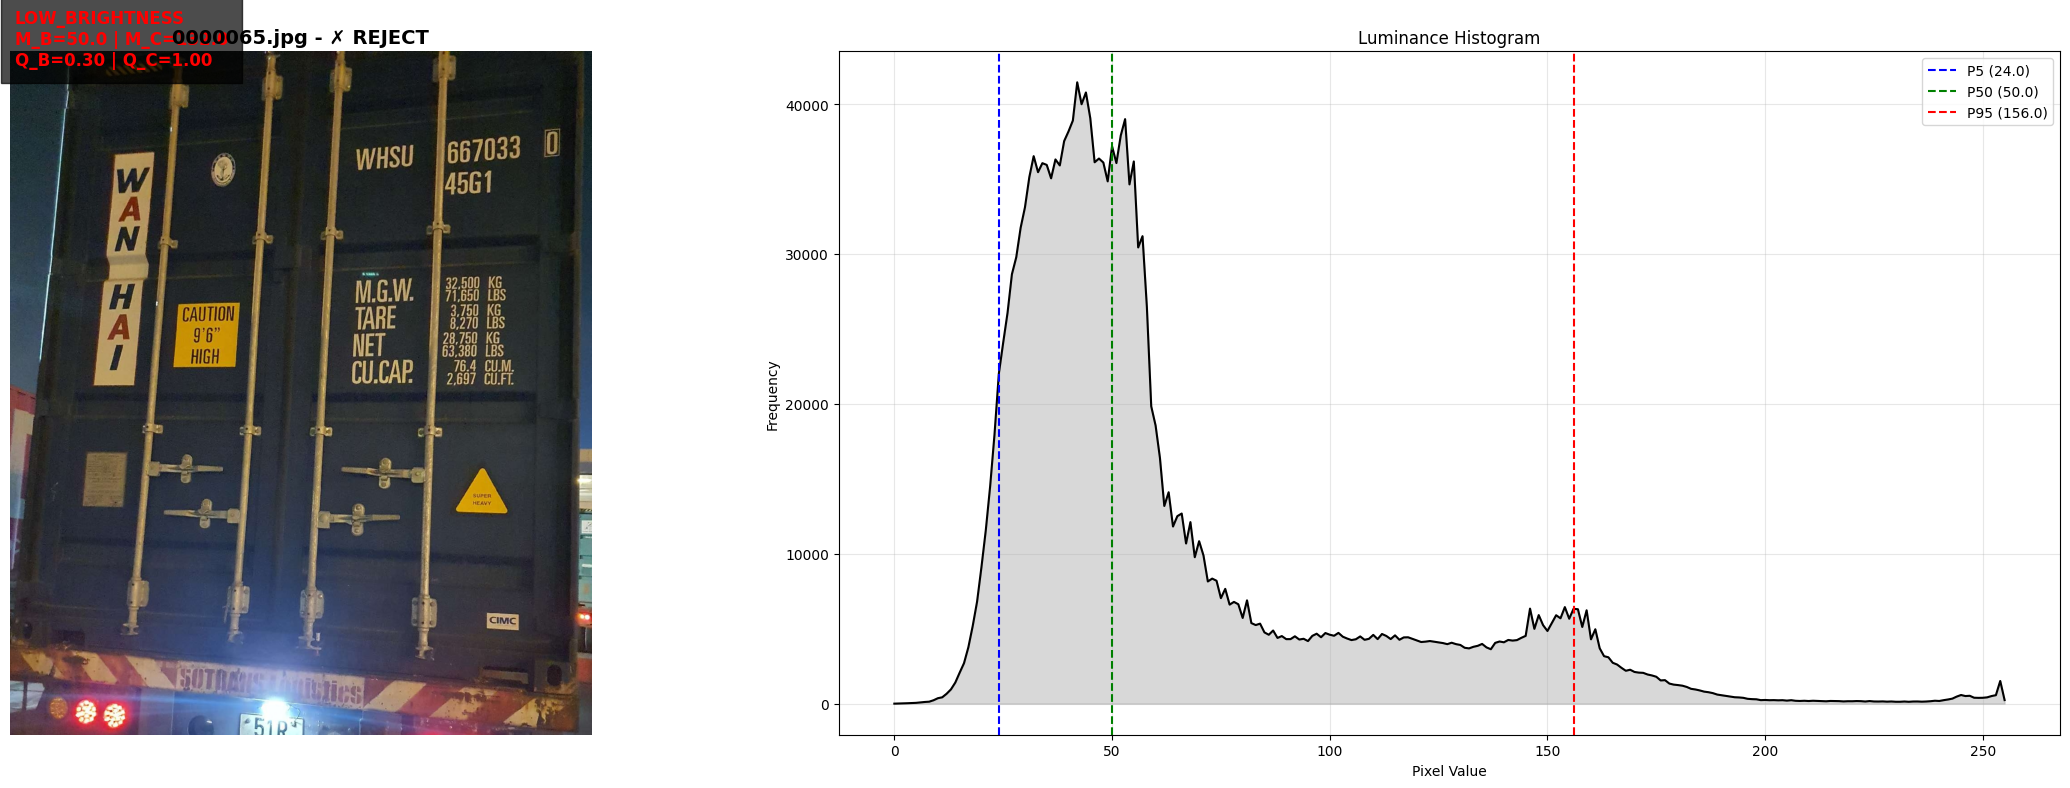

In [12]:
# Show sample REJECT images (one of each reason)
print("\n=== Sample REJECT Images ===")
reject_samples = {}
for result in results:
    if not result["passed"]:
        reason = result["reason"]
        if reason not in reject_samples:
            reject_samples[reason] = result

for reason, result in reject_samples.items():
    print(f"\nReason: {reason}")
    visualize_photometric(result, show_histogram=True)

## 10. Save Results Report

In [13]:
# Create DataFrame
df = pd.DataFrame(results)

# Save to CSV
report_path = OUTPUT_DIR / "photometric_check_report.csv"
df.to_csv(report_path, index=False)

print(f"✓ Report saved to: {report_path}")
print(f"\nReport preview:")
print(df.head(10))

✓ Report saved to: e:\container-id-research\data\interim\photometric_check_report.csv

Report preview:
     file_name    m_b    m_c       q_b       q_c  passed          reason
0  0000065.jpg   50.0  132.0  0.296176  0.999725   False  LOW_BRIGHTNESS
1  0000088.jpg   99.0  186.0  0.845185  0.999999    True            PASS
2  0000089.jpg   84.0  140.0  0.678955  0.999877    True            PASS
3  0000155.jpg  128.0  128.0  1.000000  0.999590    True            PASS
4  0000160.jpg  122.0  171.0  0.992826  0.999994    True            PASS
5  0000164.jpg  106.0  176.0  0.907738  0.999997    True            PASS
6  0000186.jpg   98.0  139.0  0.835270  0.999864    True            PASS
7  0000204.jpg  113.0  189.0  0.955997  0.999999    True            PASS
8  0000267.jpg   88.0  167.0  0.726149  0.999992    True            PASS
9  0000287.jpg  110.0  159.0  0.937255  0.999982    True            PASS


## Summary

**Task 2 Complete** ✓

**Deliverables:**
- ✓ Brightness metric (M_B) using median (P50)
- ✓ Contrast metric (M_C) using robust range (P95 - P5)
- ✓ Quality mapping functions (Gaussian for brightness, Sigmoid for contrast)
- ✓ Pass/Reject decisions based on thresholds
- ✓ CSV report: `photometric_check_report.csv`

**Key Findings:**
- Brightness target: 128 ± 50 (Gaussian tolerance)
- Contrast target: ≥ 50 (Sigmoid threshold)
- Thresholds: Q_B ≥ 0.3, Q_C ≥ 0.3

**Next Steps:**
- Proceed to **Task 3: Structural Analysis (Sharpness)**
- Use Laplacian variance for blur detection